In [ ]:
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
with open('drake_lyrics.txt', 'r') as file:
    lines = file.readlines()

# Initialize a list to store cleaned lyrics
lyrs = []

for line in lines:
    line = line.replace('\u2005', ' ').replace('\u205f', ' ')
    line = line.replace('+','').replace('à','a').replace('á','').replace('è','e').replace('é', 'e').replace('ñ','n').replace('ó','o').replace('ú','u')
    line = line.strip()  # Remove whitespace
    if "[" in line or "]" in line or "*" in line or not line: # Skip lines with brackets or empty or stars
        continue
    line = line.replace('"', '')
    lyrs.append(line)
len(lyrs)
lyrs[:5]

['Put my feelings on ice',
 'Always been a gem',
 'Certified lover boy, somehow still heartless',
 "Heart is only gettin' colder",
 'Hands are tied']

In [ ]:
chars = sorted(list(set(''.join(lyrs))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['@'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: ' ', 2: '!', 3: '$', 4: '%', 5: '&', 6: "'", 7: '(', 8: ')', 9: ',', 10: '-', 11: '.', 12: '/', 13: '0', 14: '1', 15: '2', 16: '3', 17: '4', 18: '5', 19: '6', 20: '7', 21: '8', 22: '9', 23: ':', 24: ';', 25: '?', 26: 'A', 27: 'B', 28: 'C', 29: 'D', 30: 'E', 31: 'F', 32: 'G', 33: 'H', 34: 'I', 35: 'J', 36: 'K', 37: 'L', 38: 'M', 39: 'N', 40: 'O', 41: 'P', 42: 'Q', 43: 'R', 44: 'S', 45: 'T', 46: 'U', 47: 'V', 48: 'W', 49: 'X', 50: 'Y', 51: 'Z', 52: '_', 53: 'a', 54: 'b', 55: 'c', 56: 'd', 57: 'e', 58: 'f', 59: 'g', 60: 'h', 61: 'i', 62: 'j', 63: 'k', 64: 'l', 65: 'm', 66: 'n', 67: 'o', 68: 'p', 69: 'q', 70: 'r', 71: 's', 72: 't', 73: 'u', 74: 'v', 75: 'w', 76: 'x', 77: 'y', 78: 'z', 79: '{', 80: '|', 81: '}', 82: '–', 83: '—', 84: '‘', 85: '’', 86: '“', 87: '”', 88: '…', 0: '@'}


In [ ]:
# build the dataset
block_size = 6 # context length

def build_dataset(lyrs):
    X, Y = [], []
    for l in lyrs:
        context = [0] * block_size  # Initialize a context with zeros
        for ch in l + '@':
            ix = stoi[ch]  # Map character to integer using stoi
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # Crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(lyrs)
n1 = int(0.8*len(lyrs))
n2 = int(0.9*len(lyrs))

Xtr, Ytr = build_dataset(lyrs[:n1])
Xdev, Ydev = build_dataset(lyrs[n1:n2])
Xte, Yte = build_dataset(lyrs[n2:])

torch.Size([588842, 6]) torch.Size([588842])
torch.Size([72151, 6]) torch.Size([72151])
torch.Size([74706, 6]) torch.Size([74706])


In [ ]:
tensor_decode = Ytr[:1000]
decoded_text = ''.join([itos[int(i)] for i in tensor_decode])
decoded_text

"And shittin on the men they get engaged to@Waved up, goin' up, glowin' up, growin' up@Maybe I'm hearing things cause I'm feeling like I'm faded@You know what I'm@Of somethin fast and I'm good man I'm easy to please@Having conversations with mama, man, my life is a mess@I was looking for the one@You niggas sweet, like the pussy in which I eat@Despite what you said, despite what you choose to do with yourself this summer@I just set the bar, niggas fall under it like a limbo@Aw, yeah, yeah, yeah@And then they start to R.I.P. about it@All my G's are blessed, we check in for them@These niggas make it so hard to be friendly@And I'll be the only one she concerned with@I don't get it, it's like my fairy was sick@Yeah Trendsetters@All you do is lie to me@I know rappers that call paparazzi to come and get 'em@I am convinced that my calls are being recorded@LOLOL, I'm glad you find this shit amusin'@Man really feel no ways, these man waste@I'm just gettin' started, oh, yeah, we got it bitch@Chec

In [ ]:
output_size = 89
embed_dims = 12
fc_neurons = 250

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((output_size, embed_dims), generator = g)
W1 = torch.randn((block_size*embed_dims, fc_neurons), generator = g) #6, 100
b1 = torch.randn(fc_neurons, generator = g) #100
W2 = torch.randn((fc_neurons, output_size), generator = g) #100, 89
b2 = torch.randn(output_size, generator = g) #89
params = [C, W1, b1, W2, b2]
sum(p.nelement() for p in params)

41657

In [ ]:
C[Xtr.int()].shape
#Xtr[13,2]
#C[Xtr][13,2] == C[67]

torch.Size([588842, 6, 12])

In [ ]:
for p in params:
  p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []

In [ ]:
for i in range (400000):

  ix = torch.randint(0, Xtr.shape[0], (64,))

  #forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1,embed_dims*block_size) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  #backward pass
  for p in params:
    p.grad = None
  loss.backward()

  lr = 0.1 if i < 100000 else 0.01
  for p in params:
    p.data += -lr * p.grad

  #lr = lrs[i]
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

1.7343791723251343


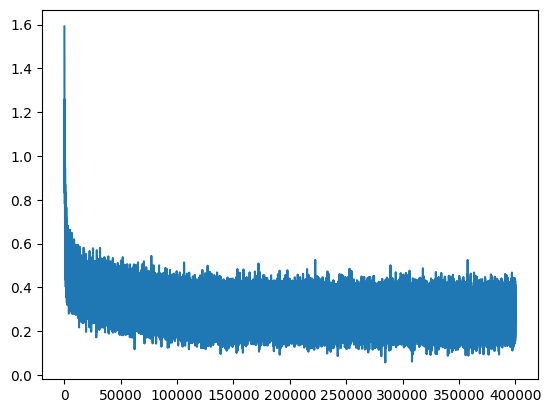

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
C[Xtr].shape
p.grad.shape
p.data.shape

torch.Size([89])

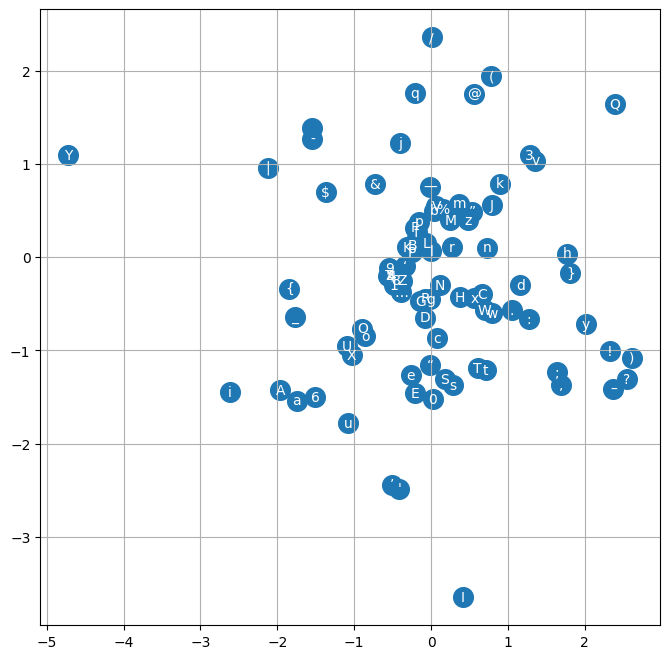

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 9)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

That's oinat@
Hadoin'@
Gitte to lauthere to nome toam, no in@
Fuck you're ceing piked, Land you the noO pame, wata shis@
What watringsa, dos, sar'lfe@
Oh, ool eper you te!@
I just stang@
Lout you'r fiid witherepiy' too I cana tansom ohveb@
Youth I cant my that fo@
We got we tos@
Caw done' not this to, won't a tarl@
It's things it@
Baby you gats hers the see lup it, woule@
That's ofceverat-ak?, thy tay she sike money bige pee sin't the woul kfomanging tay when I’m your leeps ane het over us, it exrold qiy-rhir to ope@
Loving you tar the tilferin'l, boure a hlus@
We youyw hit place@
Be to came the is ticine, to seeps@
Oh the I'll the trather the aore@
Show an they toa, bavep off at@
Because niggs@


In [ ]:
sum( map(len, lyrs) ) / len(lyrs) #avg length of string

40.89629840546697